In [1]:
import numpy as np
import gudhi as gd
import os
import gym
import gymnasium
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
import time
import matplotlib.pyplot as plt

In [2]:
x0, y0 = 9, 9
anchor_node_ratio = 0.3

In [3]:
# the purpose of this experiment is to investigate anchor nodes strategy 
# random subset of design space is chosen for anchor nodes

## Finite Element Model of the Plane Truss structure

In [4]:
def PlaneTrussElementLength(x1,y1,x2,y2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))

In [5]:
def PlaneTrussElementStiffness(E,A,L,theta):
    x = theta*np.pi/180
    C = np.cos(x)
    S = np.sin(x)
    return E*A/L*np.array([[C*C, C*S, -C*C, -C*S],[C*S, S*S, -C*S, -S*S],
                           [-C*C, -C*S, C*C, C*S],[-C*S, -S*S, C*S, S*S]])

In [6]:
def PlaneTrussAssemble(K,k,i,j):
    K[2*i,2*i] = K[2*i,2*i] + k[0,0]
    K[2*i,2*i+1] = K[2*i,2*i+1] + k[0,1] 
    K[2*i,2*j] = K[2*i,2*j] + k[0,2] 
    K[2*i,2*j+1] = K[2*i,2*j+1] + k[0,3]
    K[2*i+1,2*i] = K[2*i+1,2*i] + k[1,0]
    K[2*i+1,2*i+1] = K[2*i+1,2*i+1] + k[1,1] 
    K[2*i+1,2*j] = K[2*i+1,2*j] + k[1,2] 
    K[2*i+1,2*j+1] = K[2*i+1,2*j+1] + k[1,3] 
    K[2*j,2*i] = K[2*j,2*i] + k[2,0] 
    K[2*j,2*i+1] = K[2*j,2*i+1] + k[2,1]
    K[2*j,2*j] = K[2*j,2*j] + k[2,2]
    K[2*j,2*j+1] = K[2*j,2*j+1] + k[2,3] 
    K[2*j+1,2*i] = K[2*j+1,2*i] + k[3,0] 
    K[2*j+1,2*i+1] = K[2*j+1,2*i+1] + k[3,1]
    K[2*j+1,2*j] = K[2*j+1,2*j] + k[3,2] 
    K[2*j+1,2*j+1] = K[2*j+1,2*j+1] + k[3,3]
    
    return K 

In [7]:
def PlaneTrussElementForce(E,A,L,theta,u):
    x = theta* np.pi/180
    C = np.cos(x)
    S = np.sin(x)
    return E*A/L*np.dot(np.array([-C, -S, C, S]),u)

In [8]:
def PlaneTrussElementStress(E,L,theta,u):
    x = theta * np.pi/180
    C = np.cos(x)
    S = np.sin(x)
    return E/L*np.dot(np.array([-C, -S, C, S]),u)

In [9]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force,  A=1e-4, E=210e6):
    K=np.zeros(shape=(2*np.max(elcon)+2,2*np.max(elcon)+2))
    for el in elcon:
        L=PlaneTrussElementLength(coord[el[0]][0],coord[el[0]][1],coord[el[1]][0],coord[el[1]][1])
        theta=np.arctan((coord[el[1]][1]-coord[el[0]][1])/(coord[el[1]][0]-coord[el[0]][0]+1e-13))*180/np.pi
        k=PlaneTrussElementStiffness(E,A,L,theta)
        K=PlaneTrussAssemble(K,k,el[0],el[1])     
    
    F = global_force
    
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)

    s=np.linalg.lstsq(K[fdof,:][:,fdof],
                      (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    compliance = F.T @ d

    return d, compliance

In [10]:
# 5 The Plane Truss Element - verification 

In [11]:
d,compliance = FEA_u(np.array([0,0,
                               4,0,
                               2,3]).reshape(3,2), 
                      elcon=np.array([[0, 1],
                                      [0, 2],
                                      [1, 2]]),
                      bc_node = [0, 1, 3],
                      bc_val = [0., 0., 0.],
                      global_force = np.array([0,0,
                                               0,0,
                                               5,-10]),
                      A=1e-4, 
                      E=210e6)

In [12]:
d

array([ 0.        ,  0.        ,  0.00111111,  0.        ,  0.00195056,
       -0.00161037])

In [13]:
compliance

0.025856550339381643

## RL model

In [14]:
class Model:
    def __init__(self, x):
        self.flag_ = True
        self.n, self.m = x.shape
        self.actions_dic={} 
        dim = int(self.n * self.m * anchor_node_ratio)
        rng = np.random.default_rng(seed=2)
        xy = np.mgrid[:self.n,:self.m].reshape(2, -1).T
        self.sample = xy.take(rng.choice(xy.shape[0], dim, replace=False), axis=0)
        
        k=0
        for it in self.sample:
            self.actions_dic[k]=(it[0], it[1])
            k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1

In [15]:
class CantileverEnv(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        self.x0 = x0
        self.y0 = y0
        self.ratio = anchor_node_ratio
        self.DIM =  self.x0 * self.y0 
        self.N_DISCRETE_ACTIONS = int(self.x0 * self.y0 * self.ratio)
        
        self.action_space = spaces.Discrete(self.N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(self.DIM)]),
                                            high=np.array([1e10 for y in range(self.DIM)]),
                                            shape=(self.DIM,),
                                           dtype=np.float64)
        
        self.x = np.zeros(( self.x0, self.y0))
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        self.ext_reward=0

        
    def step(self, action):
        
        self.M.action_space_(action, self.x)        
        self.step_+=1
                        
        raw_arr = np.concatenate((np.argwhere(self.x == 1), np.array([[0,0],[x0-1,0], [0,y0-1]])), axis=0)
        points = np.unique(raw_arr, axis=0) 

        num_nodes = len(points)
        global_force = np.zeros(num_nodes * 2)
        bc_node = []
        bc_val = []

        for i, p in enumerate(points):
            if np.array_equal(p, [0,0]) or np.array_equal(p, [x0-1,0]):
                bc_node.extend([2*i, 2*i+1])
                bc_val.extend([0, 0])

            if np.array_equal(p, [0, y0-1]):
                global_force[2*i] = -10 

        alpha_complex = gd.AlphaComplex(points=points)
        simplex_tree = alpha_complex.create_simplex_tree()
        elcon = [s[0] for s in simplex_tree.get_skeleton(1) if len(s[0]) == 2]

    
        done=False
        if len(points) > int(0.7*self.N_DISCRETE_ACTIONS):
            d, compliance = FEA_u(points, np.array(elcon), bc_node, bc_val, global_force)

            self.reward = 1/compliance
            done=True
        else:
            self.reward=0
        
                  
        if self.step_ > 0.8 * self.x0 * self.y0:
            done=True            
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
        
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done, False, dict()

    def reset(self, seed=0):
                   
        self.x = np.zeros((self.x0, self.y0))

        self.reward=0
        self.needs_reset = False
        self.step_=0
        self.ext_reward=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        pass   

    def close(self):
        pass

In [16]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

## Run

In [17]:
ts=1e6

In [18]:
# Create log dir
log_dir = "/tmp/gym310b/"
os.makedirs(log_dir, exist_ok=True)

In [19]:
# Create and wrap the environment
env = CantileverEnv()
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)
check_env(env)

In [20]:
callback = SaveOnBestTrainingRewardCallback(check_freq=50_000, log_dir=log_dir)

In [21]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()  

Num timesteps: 50000
Best mean reward: -inf - Last mean reward per episode: 20.92
Saving new best model to /tmp/gym310b/best_model.zip
Num timesteps: 100000
Best mean reward: 20.92 - Last mean reward per episode: 23.08
Saving new best model to /tmp/gym310b/best_model.zip
Num timesteps: 150000
Best mean reward: 23.08 - Last mean reward per episode: 23.52
Saving new best model to /tmp/gym310b/best_model.zip
Num timesteps: 200000
Best mean reward: 23.52 - Last mean reward per episode: 23.49
Num timesteps: 250000
Best mean reward: 23.52 - Last mean reward per episode: 23.52
Num timesteps: 300000
Best mean reward: 23.52 - Last mean reward per episode: 23.52
Num timesteps: 350000
Best mean reward: 23.52 - Last mean reward per episode: 23.52
Num timesteps: 400000
Best mean reward: 23.52 - Last mean reward per episode: 23.43
Num timesteps: 450000
Best mean reward: 23.52 - Last mean reward per episode: 23.52
Num timesteps: 500000
Best mean reward: 23.52 - Last mean reward per episode: 23.52
Num

In [22]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 9.980311365922292 min


## Inference 

In [23]:
obs = env.reset()

In [24]:
obs = obs[0]

In [25]:
i=0
ans=[]
while i < 1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, _, info = env.step(int(action))
    ans.append(obs)
    if dones:
        break
    i+=1

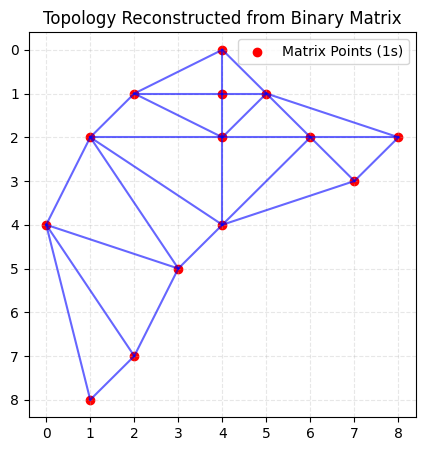

Topological Features found:
Hole/Loop exists from radius 2.5 to 3.380000000000001
Hole/Loop exists from radius 3.25 to 3.3163265306122467
Hole/Loop exists from radius 3.25 to 3.316326530612245
Component exists from radius 0.0 to inf
Component exists from radius 0.0 to 1.25
Component exists from radius 0.0 to 1.25
Component exists from radius 0.0 to 1.0
Component exists from radius 0.0 to 1.0
Component exists from radius 0.0 to 0.5
Component exists from radius 0.0 to 0.5
Component exists from radius 0.0 to 0.5
Component exists from radius 0.0 to 0.5
Component exists from radius 0.0 to 0.5
Component exists from radius 0.0 to 0.5
Component exists from radius 0.0 to 0.25
Component exists from radius 0.0 to 0.25
Component exists from radius 0.0 to 0.25


In [26]:
# 1. Convert Matrix to Point Cloud
# np.argwhere finds indices where value is 1
points = np.argwhere(np.rot90(np.array(ans[-1]).reshape(x0,y0).T, k=-1) == 1)

# 2. Build the Alpha Complex
# This reconstructs the topological structure from the discrete points
alpha_complex = gd.AlphaComplex(points=points)
simplex_tree = alpha_complex.create_simplex_tree()

# 3. Visualization
plt.figure(figsize=(5, 5))

# Plot the original matrix points
plt.scatter(points[:, 1], points[:, 0], c='red', label='Matrix Points (1s)')

# Reconstruct and plot the edges (1-simplices)
# Adjust alpha_threshold to "connect" points at different distances
alpha_threshold = 10
for simplex, filtration in simplex_tree.get_skeleton(1):
    if len(simplex) == 2 and filtration < alpha_threshold:
        p1, p2 = points[simplex[0]], points[simplex[1]]
        # Note: argwhere returns (row, col), so we plot (col, row) for (x, y)
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-', alpha=0.6)

plt.gca().invert_yaxis() # Match matrix coordinate system (top-down)
plt.title("Topology Reconstructed from Binary Matrix")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# 4. Extract Topological Invariants
persistence = simplex_tree.persistence()
print("Topological Features found:")
for dim, (birth, death) in persistence:
    feature_type = "Component" if dim == 0 else "Hole/Loop"
    print(f"{feature_type} exists from radius {birth} to {death}")

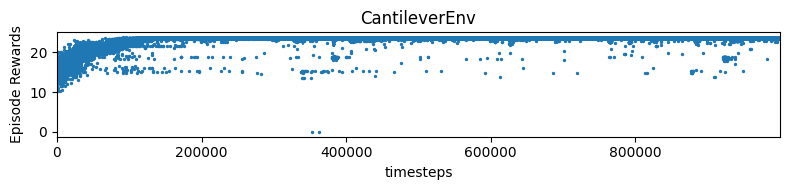

In [27]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [28]:
obs = env.reset()

In [29]:
obs = obs[0]

In [30]:
model_best = PPO.load(log_dir + "best_model.zip", env = env)

In [31]:
i=0
ans=[]
while i<1000:
    action, _states = model_best.predict(obs)
 
    obs, rewards, dones, _ , info = env.step(int(action))
    ans.append(obs)
    if dones:
        break
    
    i+=1

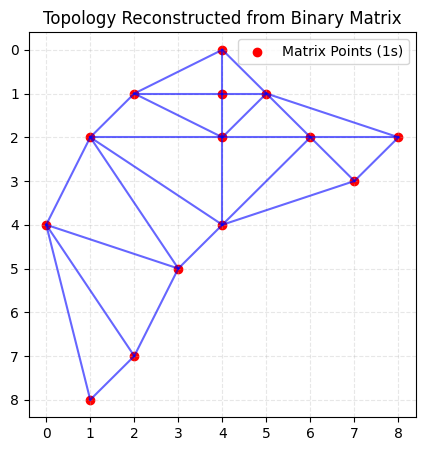

Topological Features found:
Hole/Loop exists from radius 2.5 to 3.380000000000001
Hole/Loop exists from radius 3.25 to 3.3163265306122467
Hole/Loop exists from radius 3.25 to 3.316326530612245
Component exists from radius 0.0 to inf
Component exists from radius 0.0 to 1.25
Component exists from radius 0.0 to 1.25
Component exists from radius 0.0 to 1.0
Component exists from radius 0.0 to 1.0
Component exists from radius 0.0 to 0.5
Component exists from radius 0.0 to 0.5
Component exists from radius 0.0 to 0.5
Component exists from radius 0.0 to 0.5
Component exists from radius 0.0 to 0.5
Component exists from radius 0.0 to 0.5
Component exists from radius 0.0 to 0.25
Component exists from radius 0.0 to 0.25
Component exists from radius 0.0 to 0.25


In [32]:
# 1. Convert Matrix to Point Cloud
# np.argwhere finds indices where value is 1
points = np.argwhere(np.rot90(np.array(ans[-1]).reshape(x0,y0).T, k=-1) == 1)

# 2. Build the Alpha Complex
# This reconstructs the topological structure from the discrete points
alpha_complex = gd.AlphaComplex(points=points)
simplex_tree = alpha_complex.create_simplex_tree()

# 3. Visualization
plt.figure(figsize=(5, 5))

# Plot the original matrix points
plt.scatter(points[:, 1], points[:, 0], c='red', label='Matrix Points (1s)')

# Reconstruct and plot the edges (1-simplices)
# Adjust alpha_threshold to "connect" points at different distances
alpha_threshold = 10
for simplex, filtration in simplex_tree.get_skeleton(1):
    if len(simplex) == 2 and filtration < alpha_threshold:
        p1, p2 = points[simplex[0]], points[simplex[1]]
        # Note: argwhere returns (row, col), so we plot (col, row) for (x, y)
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-', alpha=0.6)

plt.gca().invert_yaxis() # Match matrix coordinate system (top-down)
plt.title("Topology Reconstructed from Binary Matrix")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# 4. Extract Topological Invariants
persistence = simplex_tree.persistence()
print("Topological Features found:")
for dim, (birth, death) in persistence:
    feature_type = "Component" if dim == 0 else "Hole/Loop"
    print(f"{feature_type} exists from radius {birth} to {death}")